In [1]:
import torch
from numpy import polyfit
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'../code/data_utils/')
from HiCDataset import HiCDataset
sys.path.insert(1,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
save_folder='./power_law/'

Load the distance vs separation data

Only load the first 63 positions, which correspond to monomers separated by 1, ..., 63 bonds

In [3]:
mean_dists = torch.load('../data/mean_dists.pt')[:63]

Load the Hi-C data

In [4]:
exp_hic = HiCDataset('../data/outside/GM12878_hg19.mcool',resolution=20_000)

Get the mean probabilities at different distances, out to 64 monomers @ 20 kb resolution

In [5]:
mean_probs_by_chrom = torch.empty(23,63)
n_vals_per_chrom = torch.empty(23,63)
for c,chrom in enumerate([*[str(k) for k in range(1,23)],'X']):
    hic_map = exp_hic.fetch(chrom).prob_map
    n = hic_map.shape[-1]
    for i,separation in enumerate(range(1,64)):
        s = separation
        probs = hic_map[range(n-s),range(s,n)]
        mean_probs_by_chrom[c,i] = torch.nanmean(probs)
        n_vals_per_chrom[c,i] = probs.isfinite().sum()

weights = n_vals_per_chrom / n_vals_per_chrom.sum(0,keepdim=True)
mean_probs = (mean_probs_by_chrom * weights).sum(0)

In [6]:
n = 30 # Ignore monomers separated by 20 bonds or less
d = mean_dists[n:]
p = mean_probs[n:]

c,b = polyfit( d.log().numpy(), p.log().numpy(), 1)
c

-3.476506907809332

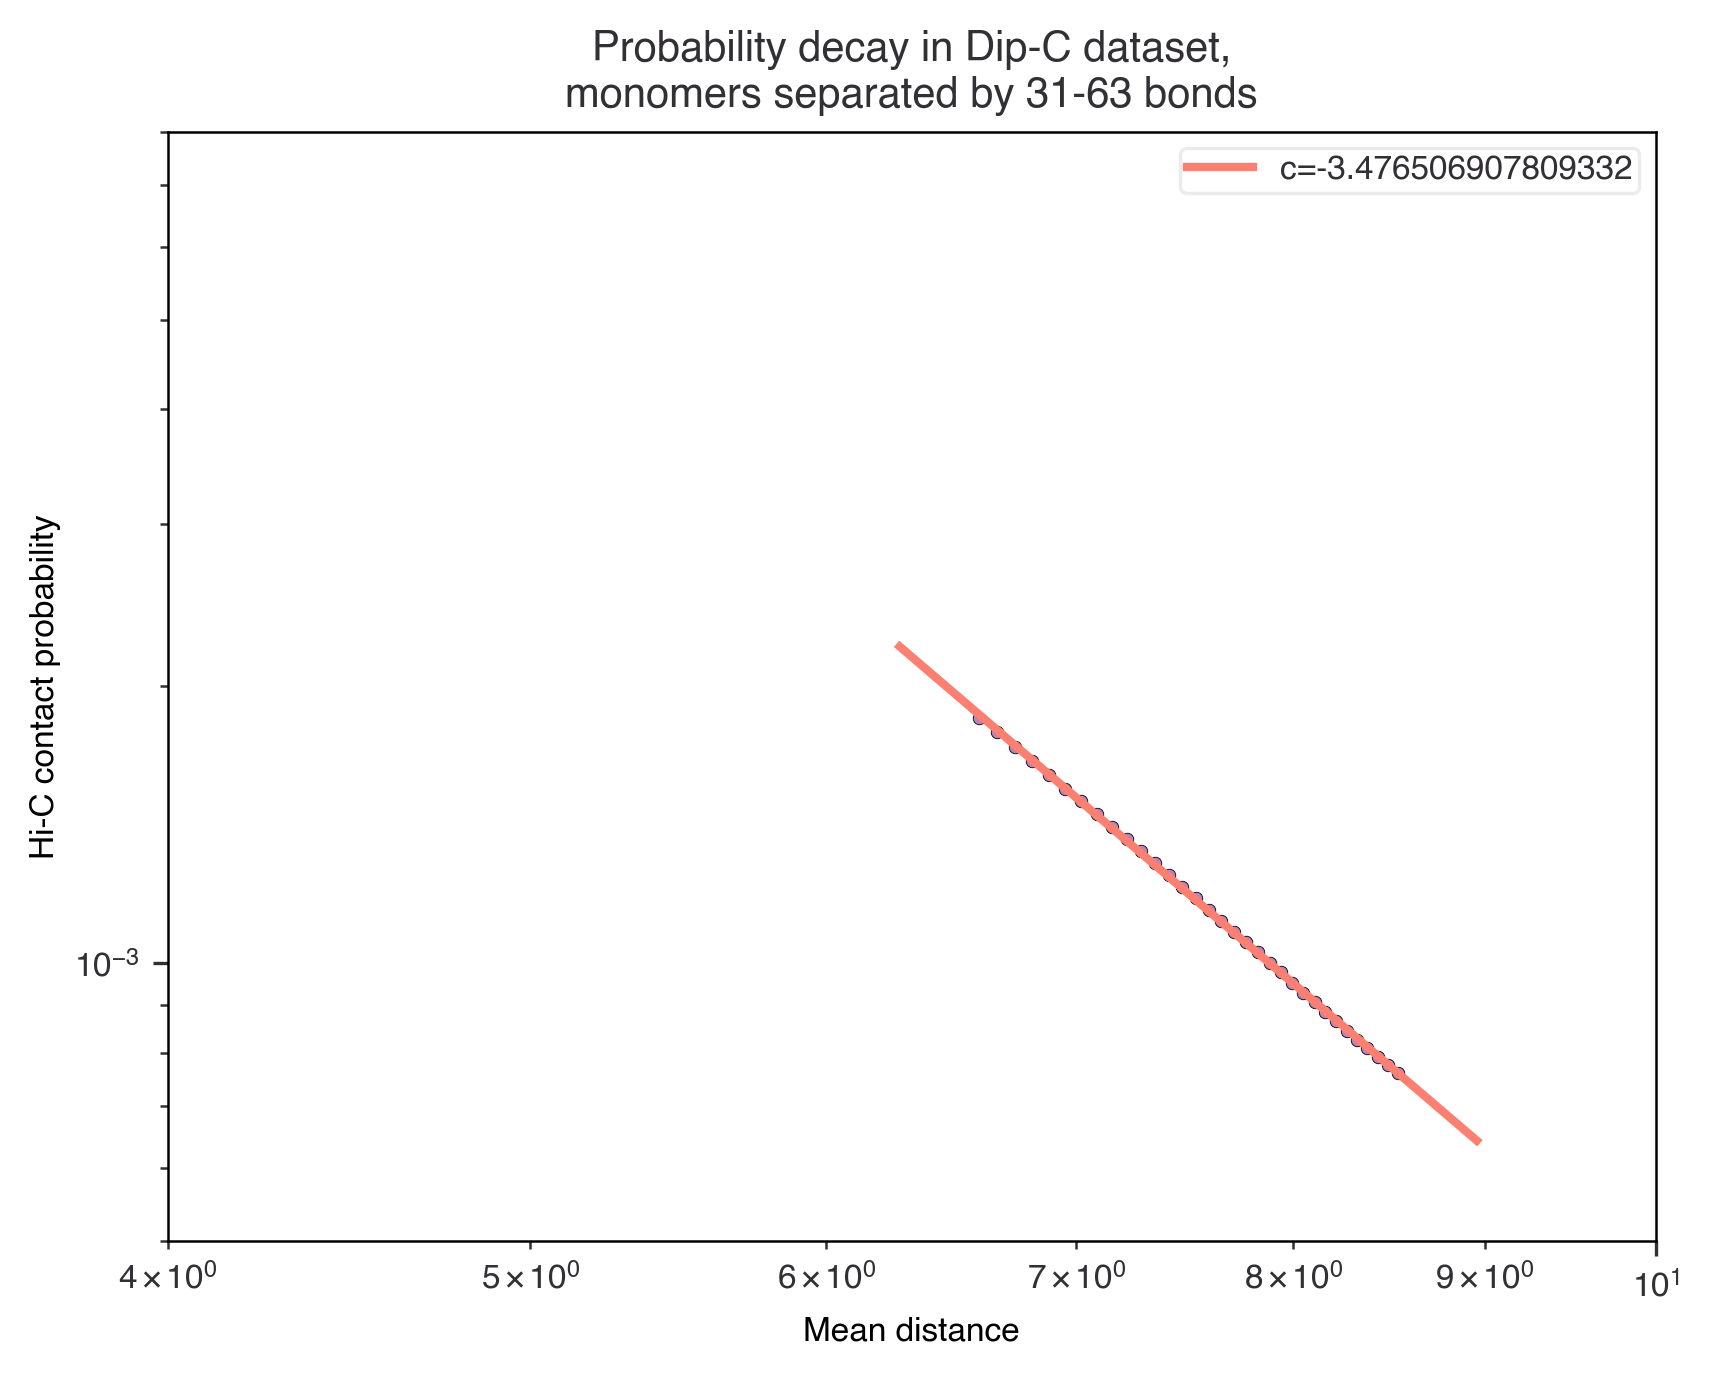

In [7]:
plt.plot(d,p,'.')
x = [d.min()*(1/1.05),d.max()*1.05]
y = [ torch.exp(dd.log() * c + b) for dd in x ]
plt.plot(x,y,label=f'c={c}')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4,10])
plt.ylim([5e-4,8e-3])
plt.xlabel('Mean distance')
plt.ylabel('Hi-C contact probability')
plt.title('Probability decay in Dip-C dataset,\n'+\
          f'monomers separated by {n+1}-63 bonds')
plt.legend()

In [8]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'H', 'M', 'P', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'multiply', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 38, 39, 43, 48, 51, 68, 69, 70, 71, 72, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 153, 1894]
INFO:fontTools.subset:Closed

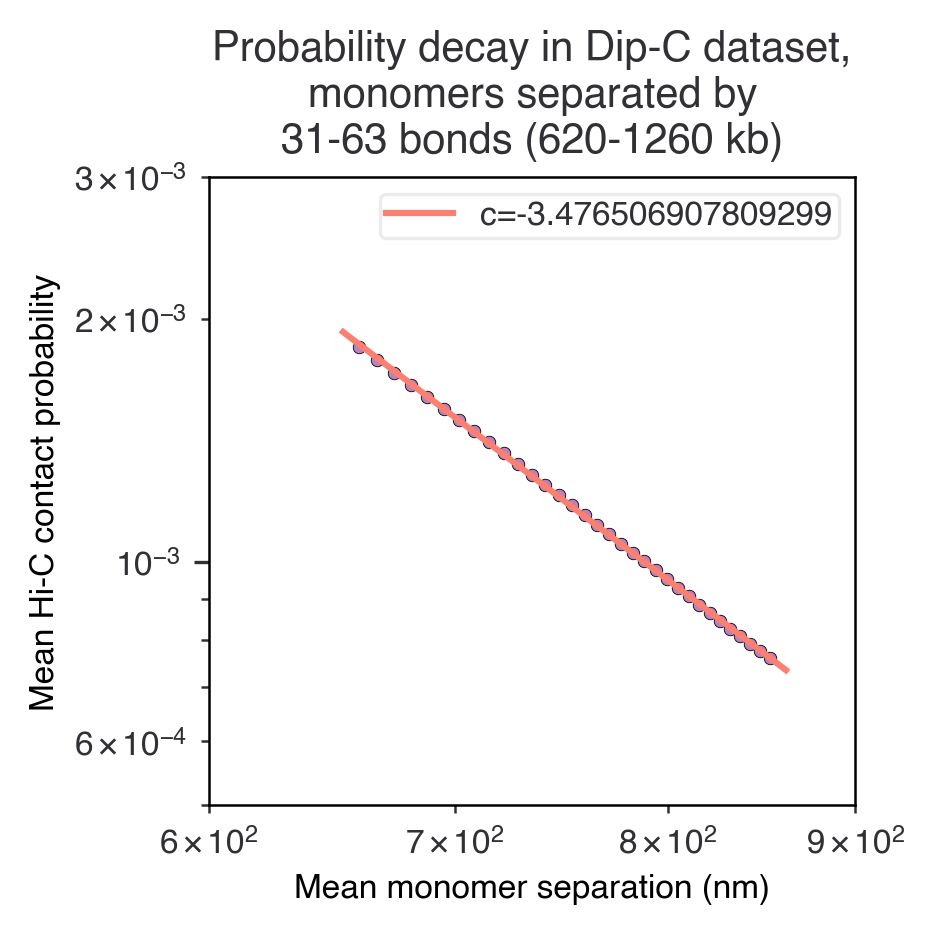

In [10]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(3,3),layout='constrained')

dd = d * 100

p = mean_probs[n:]

c,b = polyfit( dd.log().numpy(), p.log().numpy(), 1)

ax.plot(dd,p,'.')
x = [dd.min()*(1/1.01),dd.max()*1.01]
y = [ torch.exp(xx.log() * c + b) for xx in x ]
ax.plot(x,y,label=f'c={c}',linewidth=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([600,900])
ax.set_ylim([5e-4,3e-3])
ax.set_xlabel('Mean monomer separation (nm)')
ax.set_ylabel('Mean Hi-C contact probability')
ax.set_title('Probability decay in Dip-C dataset,\n'+\
          'monomers separated by\n'+f'{n+1}-63 bonds ({(n+1)*20}-{63*20} kb)')
ax.legend()

fig.savefig(save_folder + 'power_law.pdf')

#### Now do the same for generated structures

In [6]:
import torch
import sys
sys.path.insert(0,'../code/data_utils/')
from ConfigDataset import ConfigDataset

from Coordinates import coords_to_dists
from Distances import Distances

In [7]:
config_ds = ConfigDataset(
    '../data/processed_data.hdf5',
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=[0],
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

In [13]:
starts = config_ds.start_indices

In [14]:
coords = []
for i in range(64):
    coords.append(config_ds.coords[starts+i,:])

coords = torch.stack(coords,dim=1)
coords = Coordinates(coords[...,:3]).append(coords[...,3:])

In [ ]:
dists = coords_to_dists(coords.values,use_cuda=False)

In [ ]:
asdf

In [ ]:
mean_dists1 = []
for i in range(1,64):
    mean_dists1.append(dists[:,range(i,64),range(64-i)].mean())

In [ ]:
mean_dists1 = torch.tensor(mean_dists1)

In [ ]:
mean_dist_by_chrom = torch.empty(22,63)
configs_per_chrom = torch.empty(22,63)
for c,chrom in enumerate([*[str(k) for k in range(1,23)]]):#,'X']):

    config_ds = ConfigDataset(
        '../data/processed_data.hdf5',
        segment_length=64,
        remove_diagonal=False,
        batch_size=0,
        normalize_distances=False,
        geos=None,
        organisms=None,
        cell_types=None,
        cell_numbers=None,
        chroms=[chrom],
        replicates=None,
        shuffle=False,
        allow_overlap=True,
        two_channels=False,
        try_GPU=True,
        mean_dist_fp=None,
        mean_sq_dist_fp=None
    )
    starts = config_ds.start_indices
    coords = []
    for i in range(64):
        coords.append(config_ds.coords[starts+i,:])
    
    coords = torch.stack(coords,dim=1)

    dists = torch.cat(
        [
            coords_to_dists(coords[...,:3],use_cuda=False),
            coords_to_dists(coords[...,3:],use_cuda=False)
        ],
        dim=0
    )
    del coords

    for i in range(1,64):
        mean_dist_by_chrom[c,i-1] = dists[:,range(i,64),range(64-i)].mean()
        configs_per_chrom[c,i-1] = dists.shape[0]
    del dists, 

weights = configs_per_chrom / configs_per_chrom.sum(0,keepdim=True)
mean_dists1 = (mean_dist_by_chrom * weights).sum(0)

In [ ]:
import pandas as pd
base = '../data/tan_single-cell_2018/'
vals_at_dists = {}
for d in os.listdir(base):
    d1 = base + d + '/'
    files = os.listdir(d1)
    for f in files:
        if not '.impute3.round4.clean.3dg.txt.gz' in f:
            continue
        coords = pd.read_csv(d1+f,sep='\t',header=None,names=['chrom','genomic_index','x','y','z'])
        '''
        a = coords.iloc[:-1,:]
        b = coords.iloc[1:,:]

        for i in range(1,64):
            if i not in vals_at_dists:
                vals_at_dists[i] = []
            vals_at_dists[i].append(
                
            )
        '''
        
    try:
        coords
        break
    except:
        continue

In [ ]:
a = coords.iloc[:-1,:]
b = coords.iloc[1:,:]